In [1]:
import pandas as pd
import os
import numpy as np
import matplotlib.pyplot as plt
from scipy import signal

In [2]:
# calculate transition from pixelNumThreshold

def transition(NumPixel):
    NumPixel = np.asarray(NumPixel)
    PixelNumThreshold = 500
    motion = (NumPixel > PixelNumThreshold)
    FrameIdx = np.array(range(len(motion)-1))
    mothIN = FrameIdx[motion[1:] & ~motion[:-1]]+1
    mothOUT = FrameIdx[~motion[1:] & motion[:-1]]+1
    return(mothIN, mothOUT)


def smooth(Pixels):
    win_gauss = signal.gaussian(10,3)
    smooth_Pixels = signal.convolve(Pixels, win_gauss, mode='same', method = 'direct') / win_gauss.sum()
    return(smooth_Pixels)

In [4]:
path = 'G:\My Drive\Python320Kincaid-LargeDatasets\\'
data_files = [(os.path.join(root, name), name[0:-4])
               for root, dirs, files in os.walk(path)
               for name in files
               if name.endswith('.csv')]
len(data_files)

2

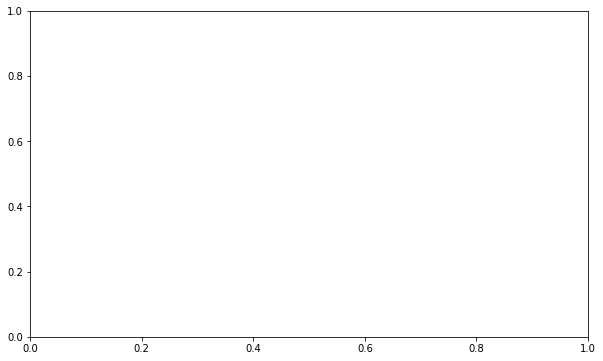

In [16]:
# %%timeit

#2 made fig object outside the for loop and cleared axes at the end of the loop
fig, ax = plt.subplots(1,1, figsize = (10,6))

for video in data_files:
    # read the details of the file and load the csv data
    filename = video[1]
#     print('working on ' + filename)

    #1 used usecols here to import only specific columns - as a result df went from ~225MB to 1.3MB
    df = pd.read_csv(video[0] , usecols = ['NumPixel'])
    
    PixelCount = np.asarray(df.NumPixel)
    Smoothened_PixelCount = smooth(PixelCount) # smoothen the Numpixels across frames
    In,Out = transition(Smoothened_PixelCount) # pull out the moth going in and out of the frame
    
    if In.size > Out.size:
        In = In[:Out.size]
    elif Out.size > In.size: 
        Out = Out[1:]
    
    FramesMothInView = Out - In
    
    #save the data in a new dataframe
    d = {'MothIN': In, 'MothOut': Out, "FramesInView" : FramesMothInView}
    new_df = pd.DataFrame(data=d)
    cols = new_df.columns.tolist()
    cols[0], cols[1], cols[2] = cols[1], cols[2], cols[0]
    new_df = new_df.reindex(columns= cols)

    if FramesMothInView.size==0:
        print(filename + " has no moth movement")
    else:
        # export figure for histogram
        binwidth = 50
        
        plt.hist(FramesMothInView, bins=range(min(FramesMothInView), max(FramesMothInView) + binwidth, binwidth))
        plt.xlabel("Total frames moth in view", fontsize = 20)
        plt.ylabel("Occurance of each bin", fontsize = 20)
        plt.cla()

#         print('done with ' + filename)

In [9]:
df.info(memory_usage='deep')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 166729 entries, 0 to 166728
Data columns (total 1 columns):
NumPixel    166729 non-null int64
dtypes: int64(1)
memory usage: 1.3 MB


In [ ]:
#3 - usecols also reduced time to run each loop!
# 3.49 s ± 69.7 ms per loop - loading only specific columns
# 8.01 s ± 502 ms per loop - loading all columns of pandas

In [19]:
%whos

Variable                Type           Data/Info
------------------------------------------------
FramesMothInView        ndarray        78: 78 elems, type `int32`, 312 bytes
In                      ndarray        78: 78 elems, type `int32`, 312 bytes
Out                     ndarray        78: 78 elems, type `int32`, 312 bytes
PixelCount              ndarray        166729: 166729 elems, type `int64`, 1333832 bytes (1.2720413208007812 Mb)
Smoothened_PixelCount   ndarray        166729: 166729 elems, type `float64`, 1333832 bytes (1.2720413208007812 Mb)
ax                      AxesSubplot    AxesSubplot(0.125,0.125;0.775x0.755)
binwidth                int            50
cols                    list           n=3
d                       dict           n=3
data_files              list           n=2
df                      DataFrame              NumPixel\n0      <...>[166729 rows x 1 columns]
fig                     Figure         Figure(720x432)
filename                str            c-1_m4
